# Train a small Dyula to French model from scratch

This Notebook uses back-translated data for training. Make sure the Notebooks to generated back-translated data are run first.

## Setup environment

Restart the kernel after you have installed packages with `pip install` in the Notebook cell below.

In [1]:
!pip install -q -U sentencepiece transformers datasets sacrebleu lxml sentence-transformers accelerate fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient 2.0.6 requires attrs<=19, but you have attrs 23.1.0 which is incompatible.


In [2]:
BASE_MODEL_ID = "facebook/nllb-200-distilled-600M"
TOKENIZER_ID = "tokenizers/tokenizer_2k"
RANDOM_SEED = 27  # Set `RANDOM_SEED = None` to run without a seed

In [3]:
from functools import partial
from transformers import NllbTokenizer
from data import (
    load_from_json,
    TranslationDataset,
    create_dataloaders
)
from modeling import (
    instantiate_small_model,
    create_learner,
    prune
)
from utils import preproc, set_seed
from translation import translate
from evaluation import calculate_bleu

In [4]:
if RANDOM_SEED is not None:
    set_seed(RANDOM_SEED, reproducible=True)

## Load training data

In [5]:
df = load_from_json(
    train_files=[
        "data/dataset_train.json",
        "data/dataset_bt_train.json",
        "data/dataset_bt_test.json",
        # "data/dataset_validation.json", "data/dataset_bt_validation.json"
    ],
    valid_files="data/dataset_validation.json",
    test_files="data/dataset_test.json",
    return_format="df"
)
print(df.shape)
df.head()

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

(98550, 3)


,dyu,fr,split
0,A bi ji min na,Il boit de l’eau.,train
1,A le dalakolontɛ lon bɛ.,Il se plaint toujours.,train
2,Mun? Fɛn dɔ.,Quoi ? Quelque chose.,train
3,O bɛ bi bɔra fo Gubeta.,Tous sortent excepté Gubetta.,train
4,A ale lo bi da bugɔ la!,Ah ! c’est lui… il sonne…,train


In [6]:
df_train = df[df["split"] == "train"].copy()
df_valid = df[df["split"]== "validation"].copy()
df_test = df[df["split"]== "test"].copy()
assert len(df_train) + len(df_valid) + len(df_test) == len(df)

## Instantiate a small Nllb-200 model
 - Vocabulary of 2000 tokens
 - 3 encoder and decoder layers
 - dimensions of linear layers 1/4 of the size of the Nllb-200-600M model

In [7]:
tokenizer = NllbTokenizer.from_pretrained(TOKENIZER_ID)
model = instantiate_small_model(
    BASE_MODEL_ID, dim_factor=4, layer_factor=4, vocab_size=tokenizer.vocab_size,
    encoder_ffn_dim=None, encoder_layers=None, decoder_ffn_dim=None, decoder_layers=None,
    num_hidden_layers=None, d_model=None, max_position_embeddings=None
)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Memory footprint: 0.02GB


## Create dataloaders

In [8]:
dls = create_dataloaders(
    df_train[["dyu", "fr"]], df_valid[["dyu", "fr"]], tokenizer, bs=128,
    src_lang="dyu_Latn", tgt_lang="fra_Latn", preproc_func=preproc,
    max_length=128
)

## Create learner and train

In [9]:
learn = create_learner(dls, model, tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn")#, wd=0.01)

We use the fastai learning rate finding to help with picking a learning rate

SuggestedLRs(valley=0.0003981071640737355)

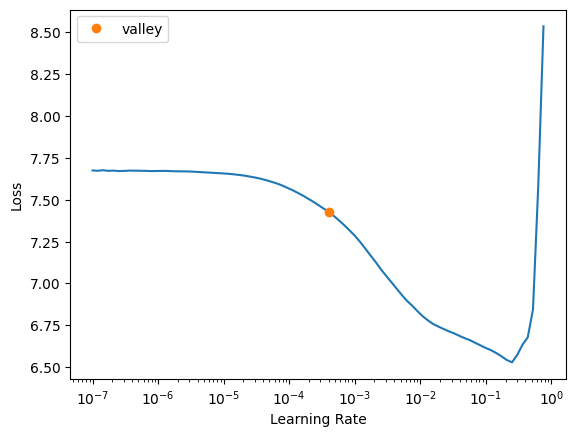

In [10]:
learn.lr_find()

In [11]:
learn.fit_sgdr(5, 1, cycle_mult=2, lr_max=1e-3)

epoch,train_loss,valid_loss,BLEU,time
0,3.159922,3.617712,2.047111,00:35
1,2.302552,3.319259,3.876464,00:35
2,1.948658,3.225243,4.970436,00:35
3,1.849716,3.362791,4.596809,00:36
4,1.510322,3.327863,4.970419,00:35
5,1.321977,3.285486,5.812019,00:36
6,1.257548,3.280746,5.639031,00:36
7,1.457664,3.437879,5.083938,00:36
8,1.323481,3.434513,5.527645,00:36
9,1.199401,3.439765,5.590034,00:37


Calculate validation BLEU:

In [12]:
translate_func = partial(
    translate, model=model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

6.159719610748194

In [13]:
MODEL_SAVE_PATH = './tmp'
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

[2024-08-30 13:34:21,005] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


## Fine-tune the model further on the original training data
(i.e., not on the backtranslated data)

In [15]:
df = load_from_json(
    train_files="data/dataset_train.json",
    valid_files="data/dataset_validation.json",
    test_files="data/dataset_test.json",
    return_format="df"
)
df_train = df[df["split"] == "train"].copy()
df_valid = df[df["split"]== "validation"].copy()
df_test = df[df["split"]== "test"].copy()
assert len(df_train) + len(df_valid) + len(df_test) == len(df)

In [16]:
dls = create_dataloaders(
    df_train[["dyu", "fr"]], df_valid[["dyu", "fr"]], tokenizer, bs=256,
    src_lang="dyu_Latn", tgt_lang="fra_Latn", preproc_func=preproc,
    max_length=128
)
learn = create_learner(dls, model, tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn")

SuggestedLRs(valley=0.0003311311302240938)

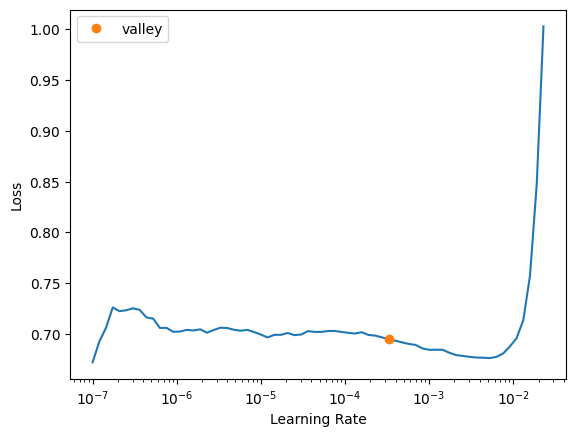

In [17]:
learn.lr_find()

In [18]:
learn.fit_flat_cos(10, 1e-4)

epoch,train_loss,valid_loss,BLEU,time
0,0.670614,3.770569,6.738084,00:03
1,0.645523,3.761546,6.751950,00:03
2,0.620735,3.760152,6.828056,00:03
3,0.594641,3.759017,6.950408,00:04
4,0.573126,3.764812,7.023500,00:03
5,0.554247,3.768945,6.872051,00:03
6,0.531228,3.776128,7.050593,00:03
7,0.511550,3.781280,7.133960,00:03
8,0.493804,3.787214,7.190992,00:03
9,0.483398,3.788148,7.085023,00:03


In [19]:
translate_func = partial(
    translate, model=model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

7.030091409276755

Convert the model to `bfloat16`:

In [20]:
model.bfloat16()
print(f"Memory footprint: {model.get_memory_footprint() / 1024**3 :.2f}GB")

Memory footprint: 0.01GB


In [21]:
translate_func = partial(
    translate, model=model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

7.258736791157131

## Save the  model

In [22]:
MODEL_SAVE_PATH = 'saved_models/nllb-dyu-fr-10MB'
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


A few test translations:

In [23]:
text = preproc(df_valid.iloc[0, 0])
print(text)
translate_func(text)

i tɔgɔ bi cogodɔ


['comment t’appelles tu']

In [23]:
text = preproc(df_valid.iloc[0, 0])
print(text)
translate_func(text)

i tɔgɔ bi cogodɔ


['comment s’appelle t il']

In [24]:
text = preproc(df_valid.iloc[1, 0])
print(text)
translate_func(text)

puɛn saba fɔlɔ


["trois points d'avance"]

In [24]:
text = preproc(df_valid.iloc[1, 0])
print(text)
translate_func(text)

puɛn saba fɔlɔ


["trois points d'avance"]

In [25]:
text = preproc(df_valid.iloc[2, 0])
print(text)
translate_func(text)

tile bena


['le soleil']

In [25]:
text = preproc(df_valid.iloc[2, 0])
print(text)
translate_func(text)

tile bena


['la journée est tombée']